In [212]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import time
import matplotlib.pylab as plt
from datasets import Dataset,DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.metrics import r2_score ,confusion_matrix ,accuracy_score
from wordcloud import WordCloud
from sklearn.neighbors import KNeighborsRegressor , KNeighborsClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Sentiment Analaysis of Reddit Posts to predict Bitcoin
*This was written by Joseph Hardin for my final in Unsupervised Learning*

Bitcoin is the most well known cryptocurrency in the world.  Cryptocurrencies, like all assests, are prone to price fluctuations due to speculation.  It is my belief that this speculation takes place in a more open and democratic way with cryptocurrency.  This speculation takes place in the open on major communication websites like Reddit and Twitter.  In this notebook I will try to look only at the sentiments of Reddit posts to see if I can predict the price of BTC for the next day.  Basically, is the 'mood' of a the main bitcoin subreddit predictive of the how the USD/BTC exchange rate changes the following day. This notebook only contains the first part of the analysis and will be 'published' before part two is complete.

# Import Reddit Data and Clean

Kaggle user **leukipp** pulls posts related to mutliple reddit cryptocurrency communities https://www.kaggle.com/datasets/leukipp/reddit-crypto-data  (THANK YOU!).  This is the source of my data, although the original is from Reddit.com/r/bitcoin.  I have spot checked several of the post and were able to verify they were indeed posted. It is updated daily so rerunning this notebook will change the data I have currently 

In [38]:
file_path = "../input/reddit-crypto-data/bitcoin/submission.csv"

data = pd.read_csv(file_path)


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60513 entries, 0 to 60512
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   submission             60513 non-null  object 
 1   subreddit              60513 non-null  object 
 2   author                 60513 non-null  object 
 3   created                60513 non-null  int64  
 4   retrieved              60513 non-null  int64  
 5   edited                 60513 non-null  int64  
 6   pinned                 60513 non-null  int64  
 7   archived               60513 non-null  int64  
 8   locked                 60513 non-null  int64  
 9   removed                60513 non-null  int64  
 10  deleted                60513 non-null  int64  
 11  is_self                60513 non-null  int64  
 12  is_video               60513 non-null  int64  
 13  is_original_content    60513 non-null  int64  
 14  title                  60504 non-null  object 
 15  li

There are multiple columns and not all have data on every row.  The feature I am most interested is the content of the **selftext** which makes up a little more than half of the posts at first glance.  However even looking at the first 10 rows , we can see the string [removed] is used as a stand in for null-data.  To clean up this data we will:

1. Clarify 'created' by renaming it to 'date_created' and converting timestamp to human readable date (YYYY-MM-DD)
2. Keep meta data about text that informs how much the community engaged with the post (upvote ratio, score, total awards recieved , total number of comments)
3. Remove any posts that have less than 20 characters of text in the selftext feature
4. Drop the rest of the features 


In [40]:
data.head(10)

,submission,subreddit,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,rt6r1a,bitcoin,boom888boom,1640995385,1641140399,0,0,0,0,1,...,off topic,1.00,3,0,0,2,0,[removed],default,https://redd.it/rt6r1a
1,rt6s86,bitcoin,[deleted],1640995487,1641140399,0,0,0,1,1,...,altcoin,0.43,0,0,0,2,0,[removed],default,https://redd.it/rt6s86
2,rt6tub,bitcoin,FSdotorg,1640995629,1641140396,0,0,0,1,1,...,altcoin,0.33,0,0,0,2,0,[removed],default,https://redd.it/rt6tub
3,rt711v,bitcoin,Squigglywiggler,1640996258,1641140399,0,0,0,0,0,...,None,0.75,12,0,0,9,0,Anyone heard any news about this? Any opinions...,self,https://redd.it/rt711v
4,rt76mj,bitcoin,BuyTheDipper,1640996745,1641140399,0,0,0,0,1,...,repetitive,0.75,2,0,0,4,0,[removed],default,https://redd.it/rt76mj
5,rt7c2v,bitcoin,Rose-Ariana,1640997244,1641140399,0,0,0,0,1,...,None,1.00,1,0,0,0,0,NaN,default,https://redd.it/rt7c2v
6,rt7qa5,bitcoin,SilverAndAlgorand,1640998555,1641140399,0,0,0,0,0,...,None,0.86,1176,0,21,510,2,I only have .03 btc but I still feel early as ...,self,https://redd.it/rt7qa5
7,rt7x3t,bitcoin,Geoknysis,1640999166,1641140399,0,0,0,0,0,...,None,0.75,2,0,0,10,0,"Okay,\n\nSo I want to move away from Exodus an...",self,https://redd.it/rt7x3t
8,rt7ymo,bitcoin,GlassDazzling5438,1640999308,1641140399,0,0,0,0,1,...,low quality,0.32,0,0,0,10,0,[removed],default,https://redd.it/rt7ymo
9,rt86pj,bitcoin,Mannycass,1641000037,1641140399,0,0,0,0,0,...,None,0.80,6,0,0,6,0,https://www.ivey.uwo.ca/faculty/directory/geor...,self,https://redd.it/rt86pj


In [41]:
data['date_created'] = (data['created']).apply(lambda x: datetime.fromtimestamp(x).date())
columns_to_keep = ["date_created", "upvote_ratio", "score", "total_awards_received", "num_comments", "selftext"]

columns_to_delete = list(data.columns.values)

for keep in columns_to_keep:
    #print(keep)
    columns_to_delete.remove(keep)
data.drop(columns_to_delete, axis = 1,inplace = True)
data = data[data ['selftext'].str.len() >= 20]
data.head(10)



,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created
3,0.75,12,0,9,Anyone heard any news about this? Any opinions...,2022-01-01
6,0.86,1176,21,510,I only have .03 btc but I still feel early as ...,2022-01-01
7,0.75,2,0,10,"Okay,\n\nSo I want to move away from Exodus an...",2022-01-01
9,0.80,6,0,6,https://www.ivey.uwo.ca/faculty/directory/geor...,2022-01-01
23,0.36,0,0,11,"Just a genuine question, I’ve googled biggest ...",2022-01-01
32,0.60,2,0,17,If people see the value going up then why is i...,2022-01-01
38,0.60,1,0,5,\nHappy New Year!! \n\nI have a burning questi...,2022-01-01
40,0.96,60,0,604,Please utilize this sticky thread for all gene...,2022-01-01
43,0.61,13,0,49,"Thank god it is on sale, idk that I could take...",2022-01-01
47,0.50,0,0,26,"I bought $1,000 AUD in BTC on 29th Jan 2021.\n...",2022-01-01


There is one more major data cleaning task for these reddit posts before moving on to bitcoin prices.  Everyday there is an automatic post for Bitcoin discussions.  None of the data collected here is the context of comments, however the metadata from this post is extremely interesting. Because the user (a bot) and the text is the  same everytime, the differences in engagement everyday *could* be generalized to the level of engagement with BTC overtime.  However, we do not want the daily posts to affect our word counts so it will be deleted.  The full context of the selftext can be seen below. 

In [85]:
sticky_message = "Please utilize this sticky thread for"

sticky_df = data[data.selftext.str.startswith(sticky_message)]
data[data['selftext'].str.contains(sticky_message).fillna(False)] = None
data.dropna(axis = 0, inplace = True)
print(sticky_df.selftext.iloc[0])

Please utilize this sticky thread for all general **Bitcoin** discussions! If you see posts on the front page or /r/Bitcoin/new which are better suited for this daily discussion thread, please help out by directing the OP to this thread instead. Thank you!

If you don't get an answer to your question, you can try phrasing it differently or commenting again tomorrow.

[Join us in the r/Bitcoin Chatroom!](https://discord.gg/K5H25KZHke)

Please check the [previous discussion thread](https://www.reddit.com/r/Bitcoin/comments/rsm1x9/daily_discussion_december_31_2021/) for unanswered questions.


# Use Tokenization and Nonnegative Matrix Factorization to begin sentiment analysis of text post

The top 2000 words (not including stop words) will be used.  The amount of topics is 5.  Both of these numbers are arbitrary and time permitting, should be subject to a grid-search.  Lastly at a later date I would like to further investigate the stop-words.  Specific websites, and even specfic sections within websites, tend to develop their own lexicon.  Augmenting the stop_words with domain specific knowledge could help preformance.

In [86]:
no_features = 2000
text_ds = data['selftext']
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text_ds)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [87]:
no_topics = 5

# Run NMF
nmf = NMF(no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
for i in range(no_topics):
    data["Topic_" + str(i)] = 0
print (data.info())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13716 entries, 3 to 60511
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   upvote_ratio           13716 non-null  float64
 1   score                  13716 non-null  float64
 2   total_awards_received  13716 non-null  float64
 3   num_comments           13716 non-null  float64
 4   selftext               13716 non-null  object 
 5   date_created           13716 non-null  object 
 6   Topic_0                13716 non-null  int64  
 7   Topic_1                13716 non-null  int64  
 8   Topic_2                13716 non-null  int64  
 9   Topic_3                13716 non-null  int64  
 10  Topic_4                13716 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.3+ MB
None


Topic 0:


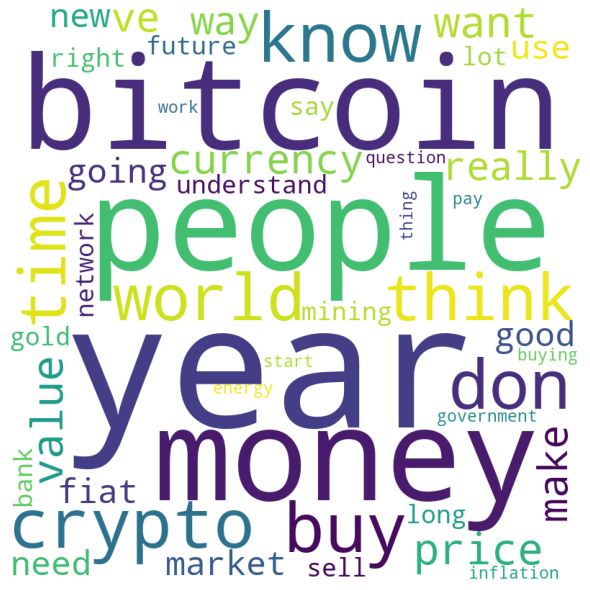

Topic 1:


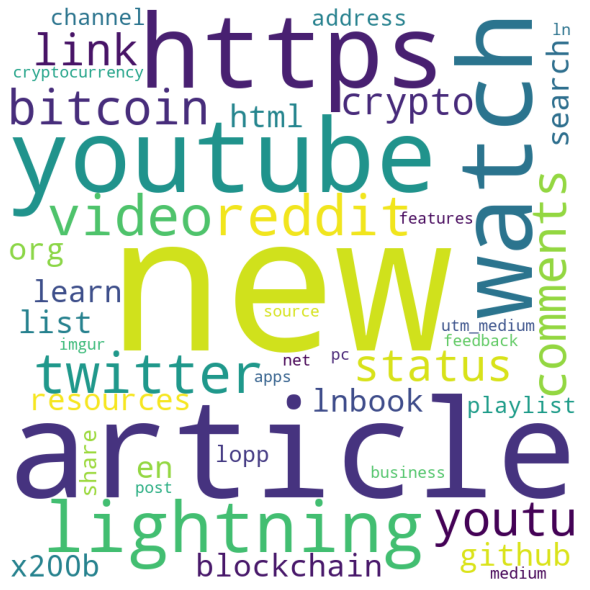

Topic 2:


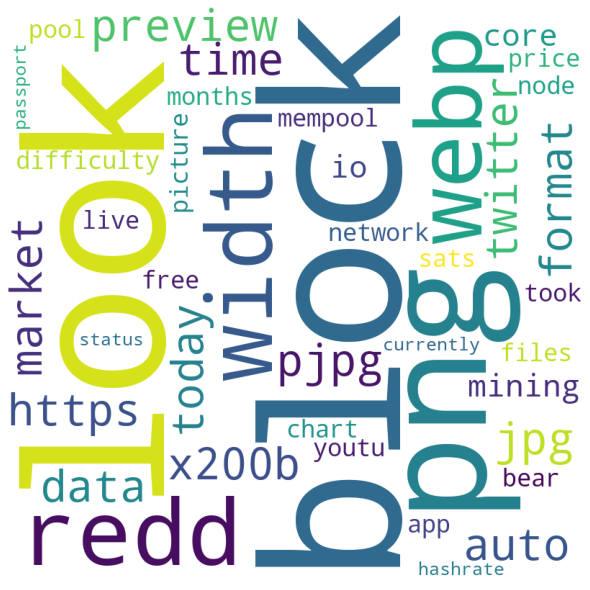

Topic 3:


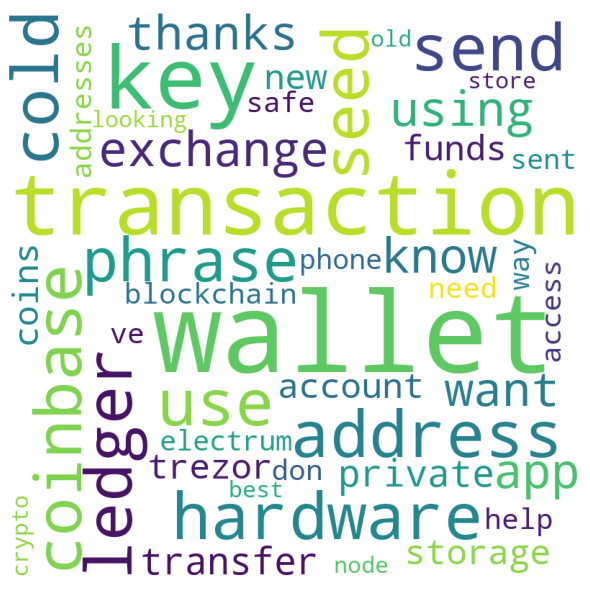

Topic 4:


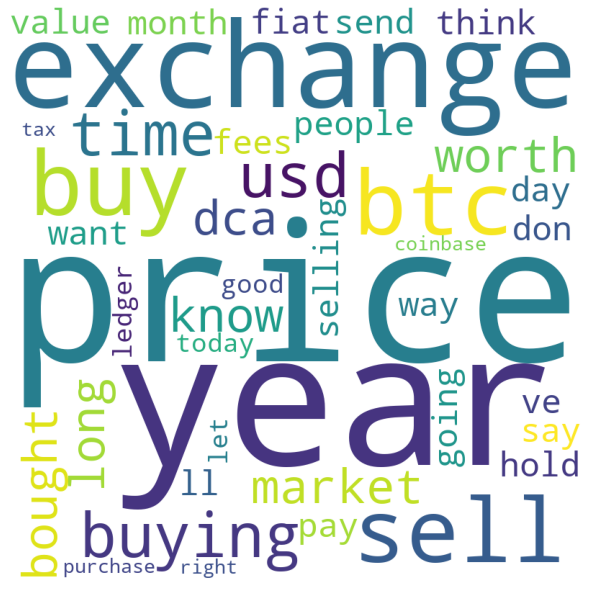

In [88]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        words = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
       #print (words)
        wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)
 
        # plot the WordCloud image                      
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
 
        plt.show()
        
no_top_words = 50

display_topics(nmf, tfidf_feature_names, no_top_words)

As stated above, at a later date I would like to look at better stop words.  Topic_2 (the 3rd one because Topic_0 exist) looks like it has many things I would consider stop words for an internet forum where people post links to picures (.jpg .png width block)

In [89]:
%%time
def topic_word_count_weighted(data, model, feature_names):
    weights  = np.sum(nmf.components_, axis = 1)  #Total weights for each category
    for i in data.index:
        best_cat = np.zeros([len(model.components_)])  
       
        for j in range(len(model.components_)):
            
            word_index = [np.where(feature_names == item) for item in data.loc[i,'selftext'].split() if item in tfidf_feature_names]
            data.loc[i, "Topic_" + str(j)] = sum([nmf.components_[j][weight] for weight in word_index])/weights[j]  # Normalizng by total weights for each category
        
    
    return data



data = topic_word_count_weighted(data, nmf, tfidf_feature_names )



CPU times: user 6min 26s, sys: 283 ms, total: 6min 27s
Wall time: 6min 27s


<AxesSubplot:>

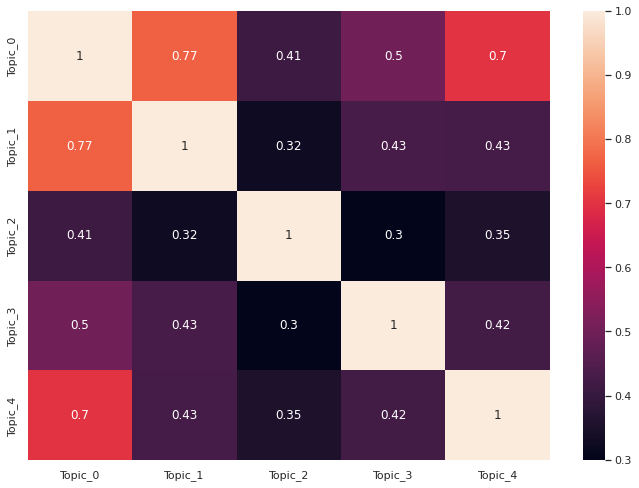

In [135]:
Topics = []
for i in range(no_topics):
    Topics.append("Topic_" + str(i))

sns.heatmap(data[Topics].corr(), annot = True)

Topic 0 has two pretty strong correlations (Topic 1 and Topic 4).  

In [90]:
data.head(10)

,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
3,0.75,12.0,0.0,9.0,Anyone heard any news about this? Any opinions...,2022-01-01,0.013024,0.008933,0.000000,0.002626,0.022608
6,0.86,1176.0,21.0,510.0,I only have .03 btc but I still feel early as ...,2022-01-01,0.035910,0.000346,0.000152,0.021722,0.159232
7,0.75,2.0,0.0,10.0,"Okay,\n\nSo I want to move away from Exodus an...",2022-01-01,0.033301,0.008890,0.001533,0.203417,0.024161
9,0.80,6.0,0.0,6.0,https://www.ivey.uwo.ca/faculty/directory/geor...,2022-01-01,0.027270,0.018217,0.000569,0.011604,0.017154
23,0.36,0.0,0.0,11.0,"Just a genuine question, I’ve googled biggest ...",2022-01-01,0.055971,0.017215,0.002175,0.118152,0.034594
32,0.60,2.0,0.0,17.0,If people see the value going up then why is i...,2022-01-01,0.025722,0.008862,0.000086,0.010308,0.018052
38,0.60,1.0,0.0,5.0,\nHappy New Year!! \n\nI have a burning questi...,2022-01-01,0.019368,0.005447,0.000794,0.023362,0.024612
43,0.61,13.0,0.0,49.0,"Thank god it is on sale, idk that I could take...",2022-01-01,0.002486,0.000000,0.000022,0.001101,0.003265
47,0.50,0.0,0.0,26.0,"I bought $1,000 AUD in BTC on 29th Jan 2021.\n...",2022-01-01,0.033542,0.015516,0.000000,0.080641,0.006957
49,0.72,23.0,0.0,106.0,Just wondering how many of you guys are actual...,2022-01-01,0.020367,0.002456,0.001932,0.017487,0.021528


In [91]:
data.to_pickle("/kaggle/working/data.pkl")  
data = pd.read_pickle("/kaggle/working/data.pkl")

# Import Prices , Clean Data, and Transform

A Kaggle User SRK (THANK YOU!) uses CoinGecko to pull cryptocurrency price information  https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrency-historical-prices-coingecko/versions/57  It is from here that the USD/BTC price infromation is captured.  Although the total_volume information could be useful, the only thing I am interested in is the price of the coin and the date. 

1. Drop all information but price and date
2. Drop time from timedate format as it is too granualar 
3. Focus only on 2022 because that is the same timeframe as the Reddit Data 
4. Calculate the percent change from the current day to the next "x" day

    a. The Days forecasted are 1,3,5,7,10 days into the 'future'  
    
    b. If the forecast is a percent increase a '1' is assigned to that days binary column.  '0' is for no change or negative.  
    
    c. For Example if the price goes from 100 on day 0 to 90 on day 1, day 1 forecast will be -0.1 to represent the drop by 10 percent and day 1b forecast will be 0



In [62]:
prices = pd.read_csv('../input/cryptocurrency-historical-prices-coingecko/bitcoin.csv')
prices.head(10)

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.9920,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.4460,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.5720,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.9360,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.2200,1.550381e+08,3.740880e+09,bitcoin
5,2015-01-06 00:00:00.000,285.3738,9.700290e+07,3.908408e+09,bitcoin
6,2015-01-07 00:00:00.000,295.8725,1.106742e+08,4.053239e+09,bitcoin
7,2015-01-08 00:00:00.000,284.4525,8.657054e+07,3.897824e+09,bitcoin
8,2015-01-09 00:00:00.000,289.5738,8.347840e+07,3.968993e+09,bitcoin
9,2015-01-10 00:00:00.000,274.5330,9.268384e+07,3.763909e+09,bitcoin


In [63]:

def add_price_forecast(prices, forecast_days):
    col_names = prices.columns
    # First Start fresh by deleting any previous forecast data"
    end_date = max(prices['date'])
    print(col_names)
    for col in col_names:
        if col.startswith("forecast"):
            prices.drop(col, axis = 1, inplace = True)
    
    for day in forecast_days:
        prices["forecast_" + str(day)] = 0
        prices["forecast_" + str(day) +"b"] = 0  #b for binary
    
   
    for i in prices.index:
        for days in forecast_days:
            stop_date = i +  days
            
            
            if stop_date < len(prices):
                try:
                    prices.loc[i, "forecast_" + str(days)] = (prices.loc[stop_date,'price'] - prices.loc[i,'price']) / prices.loc[i,'price']
                    if prices.loc[i, "forecast_" + str(days)] > 0:
                        prices.loc[i,"forecast_" + str(days) +"b"] = 1
                except Exception as e:
                    None
                    print(e)
                
        
    
    return prices






try:
    prices['date'] = (prices['date']).apply(lambda x: datetime.fromisoformat(x).date())
except Exception as e:
    print(e)
try:
    prices.drop(['total_volume', 'market_cap', 'coin_name'] ,axis = 1, inplace = True)
    
except:
    None
prices.head(10)
forecast_days = [1,3,5,7,10]



In [64]:
prices = add_price_forecast(prices, forecast_days)
print("Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))
print("Reddit Data ranges from " , min(data['date_created']), " to " , (max(data['date_created'])))
prices = prices[prices['date'] > min(data['date_created'])]
print("New Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))

prices.head(10)


Index(['date', 'price'], dtype='object')
Price Data ranges from  2015-01-01  to  2022-11-17
Reddit Data ranges from  2022-01-01  to  2022-11-17
New Price Data ranges from  2022-01-02  to  2022-11-17


,date,price,forecast_1,forecast_1b,forecast_3,forecast_3b,forecast_5,forecast_5b,forecast_7,forecast_7b,forecast_10,forecast_10b
2557,2022-01-02,47816.077676,-0.008969,0,-0.039277,0,-0.096194,0,-0.126723,0,-0.105380,0
2558,2022-01-03,47387.212168,-0.018065,0,-0.078926,0,-0.123662,0,-0.116589,0,-0.071862,0
2559,2022-01-04,46531.140861,-0.012747,0,-0.071236,0,-0.102608,0,-0.100176,0,-0.084303,0
2560,2022-01-05,45938.024272,-0.049869,0,-0.096017,0,-0.088721,0,-0.068806,0,-0.061325,0
2561,2022-01-06,43647.147508,-0.009868,0,-0.043313,0,-0.040719,0,0.007669,1,-0.009634,0
2562,2022-01-07,43216.458677,-0.039088,0,-0.031333,0,-0.010164,0,-0.014070,0,-0.002237,0
2563,2022-01-08,41527.197043,0.005526,1,0.008252,1,0.059110,1,0.038376,1,0.018570,1
2564,2022-01-09,41756.662324,0.002531,1,0.024440,1,0.020398,1,0.035204,1,0.015298,1
2565,2022-01-10,41862.360986,0.000179,1,0.050631,1,0.030063,1,0.030037,1,-0.002695,0
2566,2022-01-11,41869.859056,0.021671,1,0.017639,1,0.032405,1,0.010234,1,-0.027757,0


In [92]:
prices.to_pickle("/kaggle/working/prices.pkl")  
prices = pd.read_pickle("/kaggle/working/prices.pkl")

Bitcoin has not had the best year.  This graph is even a little worse than it looks because the USD is experiencing inflation

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


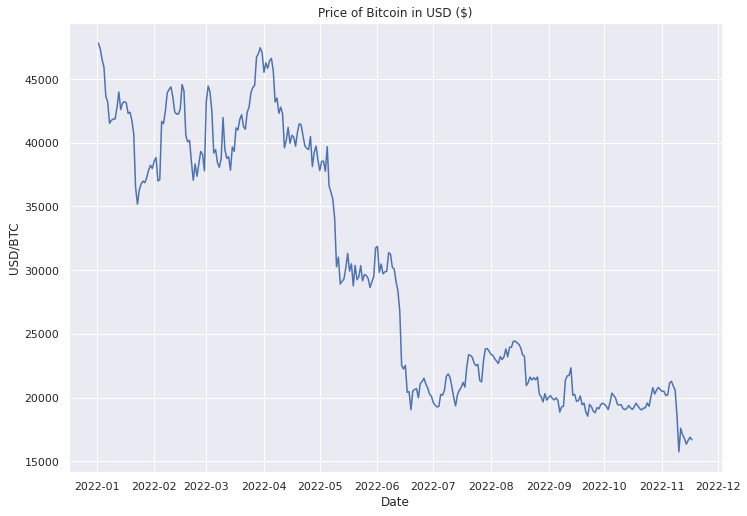

In [74]:
ax = sns.lineplot(prices['date'], prices['price'])
ax.set(title = "Price of Bitcoin in USD ($)", ylabel = 'USD/BTC', xlabel = "Date")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


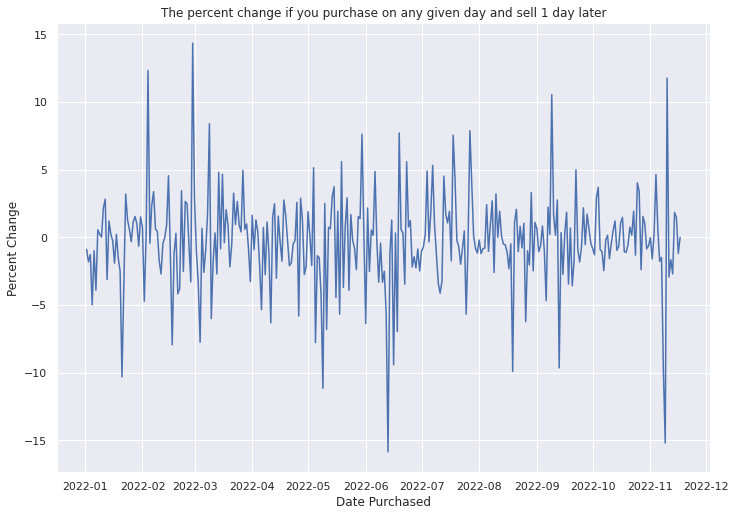

In [76]:
ax = sns.lineplot(prices['date'], prices['forecast_1']*100)
ax.set(title = "The percent change if you purchase on any given day and sell 1 day later", ylabel = 'Percent Change', xlabel = "Date Purchased")
plt.show()

Even though BTC has had a rough year, there are just slightly more days where the price of bitcoin goes down (0) than when it goes up (1).  That means that there is still money to be made if we can properly time these fluctuations

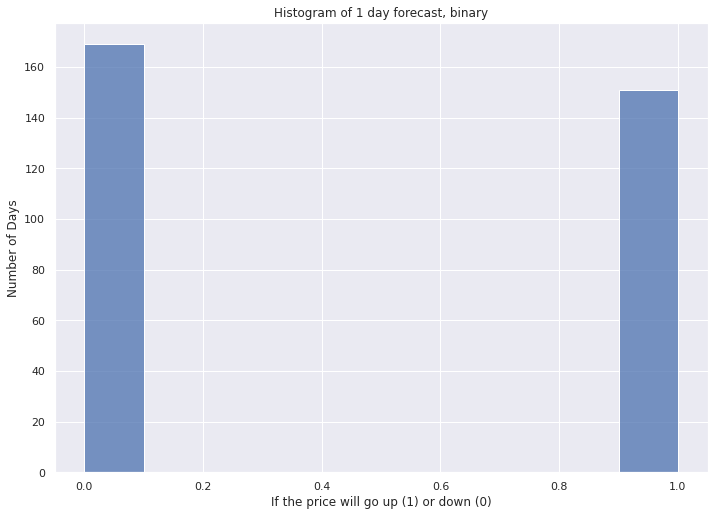

In [68]:
ax = sns.histplot(prices['forecast_1b'])
ax.set(xlabel = "If the price will go up (1) or down (0)", ylabel = 'Number of Days', title = "Histogram of 1 day forecast, binary")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


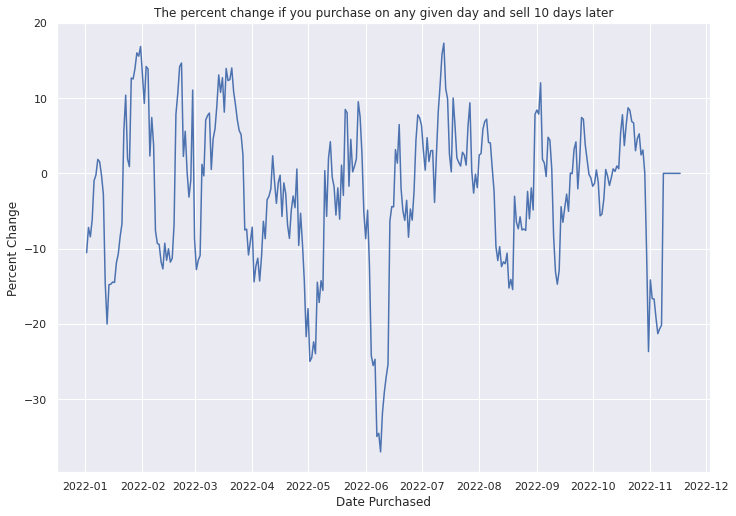

In [75]:
ax = sns.lineplot(prices['date'], prices['forecast_10']*100)
ax.set(title = "The percent change if you purchase on any given day and sell 10 days later", ylabel = 'Percent Change', xlabel = "Date Purchased")
plt.show()

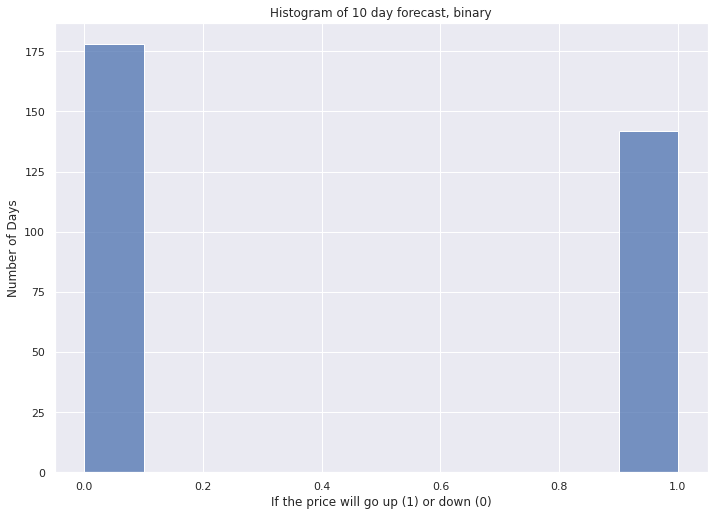

In [69]:
ax = sns.histplot(prices['forecast_10b'])
ax.set(xlabel = "If the price will go up (1) or down (0)", ylabel = 'Number of Days', title = "Histogram of 10 day forecast, binary")
plt.show()

# Further Data Analysis/Visualization:  Comparing BTC price to Reddit Behavior

In [81]:
best_1day_date = prices.date[prices.forecast_1 == prices.forecast_1.max()].values[0]

print("The best day to buy for only 1 day was ",  best_1day_date,
      " because the next day the price went up ", round(100*prices.forecast_1[prices.forecast_1 == prices.forecast_1.max()].values[0] , 1), "%")
best_1day_df = data[data.date_created == best_1day_date]
best_1day_df.sort_values(by = ['score'],axis=0, ascending=False, inplace=True)
print("There were a total of ", len(best_1day_df), " reddit text posts that day that were longer than 20 characters.  Below are the most upvoted")
best_1day_df.head(10)



The best day to buy for only 1 day was  2022-02-28  because the next day the price went up  14.3 %
There were a total of  67  reddit text posts that day that were longer than 20 characters.  Below are the most upvoted


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
14780,0.92,1195.0,0.0,224.0,The past few weeks should be all the evidence ...,2022-02-28,0.048887,0.000000,0.001197,0.010197,0.025474
14704,0.88,555.0,3.0,164.0,"With inminent expulsion from SWIFT, Russian ba...",2022-02-28,0.006291,0.000000,0.000000,0.000359,0.000781
14786,0.93,366.0,3.0,199.0,I just traded all my crypto into BTC.\n\nWith ...,2022-02-28,0.052126,0.000000,0.000344,0.009561,0.015612
14782,0.88,252.0,0.0,117.0,How soon before bitcoin explodes with Russians...,2022-02-28,0.034886,0.035964,0.000189,0.016425,0.003246
14865,0.91,133.0,0.0,19.0,"Been hodling since 2014, was very interested i...",2022-02-28,0.089557,0.058298,0.003016,0.026493,0.018846
14902,0.95,94.0,0.0,24.0,[Block 725338](https://blockstream.info/block/...,2022-02-28,0.006306,0.000000,0.003114,0.000000,0.028434
14684,0.88,72.0,0.0,31.0,I am amazed every week by something that BTC i...,2022-02-28,0.044655,0.018351,0.002982,0.003885,0.040868
14774,1.00,56.0,0.0,20.0,Imagine a future where a user Alice has bitcoi...,2022-02-28,0.325659,0.288477,0.016469,0.222110,0.426892
14845,0.90,46.0,0.0,103.0,Thinking of stopping my weekly 401k contributi...,2022-02-28,0.002329,0.000000,0.000387,0.000482,0.007699
14728,0.89,38.0,0.0,6.0,Bitcoin got what it needs for the pump,2022-02-28,0.002680,0.000000,0.000000,0.000000,0.003211


In [102]:

worst_1day_date = prices.date[prices.forecast_1 == prices.forecast_1.min()].values[0]

print("The best day to buy for only 1 day was ",  worst_1day_date,
      " because the next day the price went down ", round(100*prices.forecast_1[prices.forecast_1 == prices.forecast_1.min()].values[0] , 1), "%")
worst_1day_df = data[data.date_created == worst_1day_date]
worst_1day_df.sort_values(by = ['score'],axis=0, ascending=False, inplace=True)
print("There were a total of ", len(worst_1day_df), " reddit text posts that day that were longer than 20 characters.  Below are the most upvoted")
worst_1day_df.head(10)

The best day to buy for only 1 day was  2022-06-13  because the next day the price went down  -15.8 %
There were a total of  120  reddit text posts that day that were longer than 20 characters.  Below are the most upvoted


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
35239,0.96,558.0,2.0,102.0,I missed the 2018-2019 vibes,2022-06-13,0.000251,0.000000,0.000000,0.000000,0.000046
35124,0.86,451.0,0.0,333.0,I know I am. Let it plunge can clear out thes...,2022-06-13,0.006661,0.000058,0.000000,0.007963,0.005104
35062,0.78,404.0,7.0,293.0,"Panic is over 9000 in this subreddit, why don’...",2022-06-13,0.042086,0.001069,0.000226,0.020181,0.084792
34903,0.69,246.0,3.0,225.0,Raise your hand if you’re loving this price!!!,2022-06-13,0.000440,0.000000,0.000000,0.000132,0.000337
35054,0.81,214.0,0.0,126.0,The intention of bitcoin was is to be an entir...,2022-06-13,0.184160,0.067792,0.005093,0.036556,0.067697
35198,0.76,188.0,0.0,435.0,I invested my yearly savings into btc right wh...,2022-06-13,0.083415,0.029370,0.000516,0.010654,0.250438
34956,0.76,157.0,0.0,174.0,I believe in Bitcoin. I believe one day it wil...,2022-06-13,0.035545,0.004861,0.001911,0.014963,0.063205
34948,0.94,151.0,1.0,15.0,"When I started my Bitcoin journey, this sub al...",2022-06-13,0.046487,0.005090,0.001618,0.025012,0.045806
35176,0.86,116.0,0.0,122.0,"Preface: I am a believer and a hodler, just wa...",2022-06-13,0.082320,0.018767,0.008051,0.022079,0.075568
35106,0.88,102.0,0.0,54.0,Original post:\nhttps://www.reddit.com/r/Bitco...,2022-06-13,0.000000,0.000000,0.000000,0.000000,0.000000


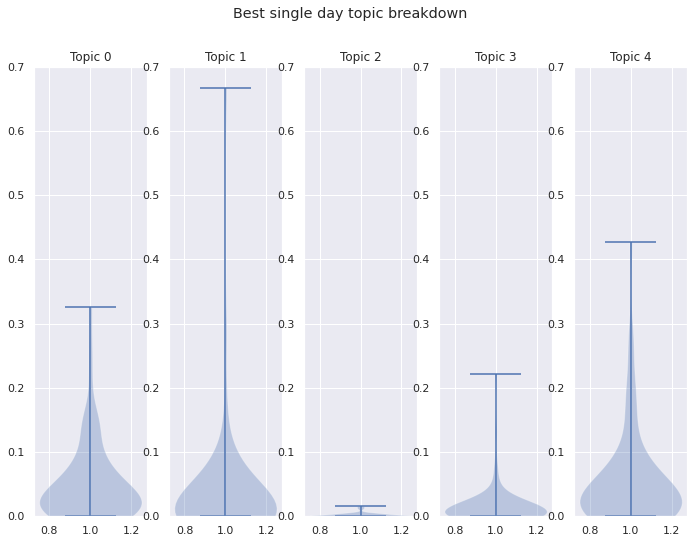

In [128]:
fig, axis = plt.subplots(nrows = 1, ncols = 5)

fig.suptitle("Best single day topic breakdown")
axis[0].violinplot(best_1day_df['Topic_0'])
axis[0].set_title("Topic 0")
axis[1].violinplot(best_1day_df['Topic_1'])
axis[1].set_title("Topic 1")
axis[2].violinplot(best_1day_df['Topic_2'])
axis[2].set_title("Topic 2")
axis[3].violinplot(best_1day_df['Topic_3'])
axis[3].set_title("Topic 3")
axis[4].violinplot(best_1day_df['Topic_4'])
axis[4].set_title("Topic 4")
for ax in axis:
    ax.set_ylim([0,.7])
plt.show()


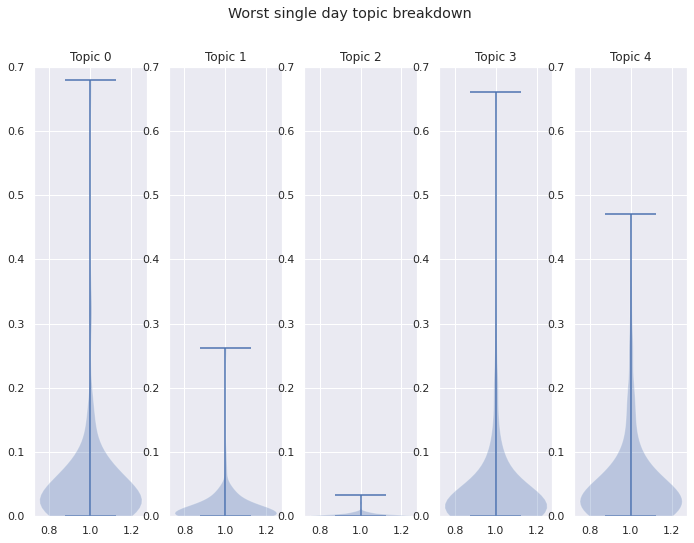

In [130]:
fig, axis = plt.subplots(nrows = 1, ncols = 5)

fig.suptitle("Worst single day topic breakdown")
axis[0].violinplot(worst_1day_df['Topic_0'])
axis[0].set_title("Topic 0")
axis[1].violinplot(worst_1day_df['Topic_1'])
axis[1].set_title("Topic 1")
axis[2].violinplot(worst_1day_df['Topic_2'])
axis[2].set_title("Topic 2")
axis[3].violinplot(worst_1day_df['Topic_3'])
axis[3].set_title("Topic 3")
axis[4].violinplot(worst_1day_df['Topic_4'])
axis[4].set_title("Topic 4")
for ax in axis:
    ax.set_ylim([0,.7])
plt.show()


It is extremely tempting to look for patterns between these violin plots.  Accoring to our hypothesis, these days represent the extremes, and the sentiments of these posts may hold the key to see what are our principal compnenets. However the only thing I felt comfortable taking away was the max value would make for a very poor single point representive of the topics when grouped by day.  Furtermore they are all biased towards 0 so picking out a percintile higher than mean can help give some clue as to shape.  As will be seen below, the mean and the 85th percintile were chosen.

<AxesSubplot:>

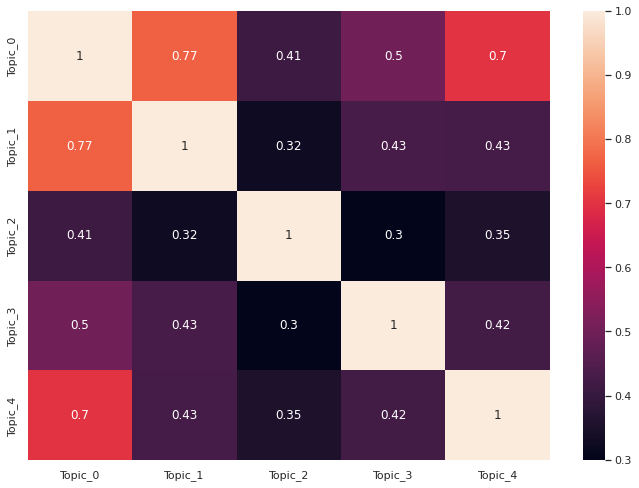

In [135]:
Topics = []
for i in range(no_topics):
    Topics.append("Topic_" + str(i))

sns.heatmap(data[Topics].corr(), annot = True)

The above correlation plot is simply a repeat of above to give further context to the violin plots.

Text(0, 0.5, 'Price of Bitcoin in USD')

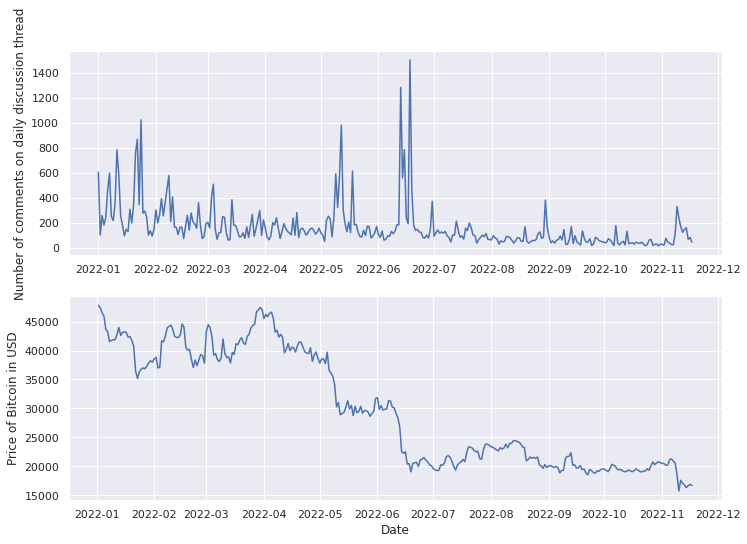

In [133]:

fig, axis = plt.subplots(2)

plt.xlabel('Date')
axis[0].plot(sticky_df['date_created'], sticky_df['num_comments'])
axis[0].set_ylabel("Number of comments on daily discussion thread")
axis[1].plot(prices['date'], prices['price'])
axis[1].set_ylabel("Price of Bitcoin in USD")

#sns.lineplot(sticky_df['date_created'], sticky_df['num_comments'])

This is not a part of the sentiment analysis, but was too interesting to leave out.  I did notice on the 'best day to invest' there were only 67 posts that met the criteria for type and length.  On the worst day to invest there was nearly double at 120.  As mentioned towards the top of this notebook, the engagement for the daily thread could be looked at as a surragote for what is happening to BTC as a whole.  By eye, when there are dips in the price of BTC the engagement skyrockets, roughly proprotional to the size of the dip.  Both points seem to indicate the best time to by BTC is if few people are talking about BTC.

# K-Nearest Neighbor for regression and classification

As shown above, the metadata provided -- especially the number of comments and the number of posts -- shows potential for being predictive of price fluctuations.  However, my original hypothesis was the sentiment behind selftext posts was predictive and I won't let something like profit get in the way of a pure quest for knowledge. 

In [157]:
topic_features = ['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_0_85th', 'Topic_1_85th', 'Topic_2_85th', 'Topic_3_85th', 'Topic_4_85th']
topic_plus_meta = topic_features + ['upvote_ratio', 'score', 'total_awards_received', 'num_comments', 'num_posts']

df_topic_1 =  pd.DataFrame(columns = topic_features)


df_topic_1['date']  = prices['date']
df_topic_1['y']  =  prices['forecast_1'] 
df_topic_1['y_b'] =  prices['forecast_1b'] 

df_topic_1.set_index('date', inplace = True)


for date in df_topic_1.index:
    df_topic_1.loc[date, 'Topic_0'] = np.mean(data.Topic_0[data.date_created == date])
    df_topic_1.loc[date, 'Topic_0_85th'] = np.percentile(data.Topic_0[data.date_created == date],85)
    df_topic_1.loc[date, 'Topic_1'] = np.mean(data.Topic_1[data.date_created == date])
    df_topic_1.loc[date, 'Topic_1_85th'] = np.percentile(data.Topic_1[data.date_created == date],85)
    df_topic_1.loc[date, 'Topic_2'] = np.mean(data.Topic_2[data.date_created == date])
    df_topic_1.loc[date, 'Topic_2_85th'] = np.percentile(data.Topic_2[data.date_created == date],85)
    df_topic_1.loc[date, 'Topic_3'] = np.mean(data.Topic_3[data.date_created == date])
    df_topic_1.loc[date, 'Topic_3_85th'] = np.percentile(data.Topic_3[data.date_created == date],85)
    df_topic_1.loc[date, 'Topic_4'] = np.mean(data.Topic_4[data.date_created == date])
    df_topic_1.loc[date, 'Topic_4_85th'] = np.percentile(data.Topic_4[data.date_created == date],85)
    

In [216]:
df_topic_1.head(10)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_0_85th,Topic_1_85th,Topic_2_85th,Topic_3_85th,Topic_4_85th,y,y_b
date,,,,,,,,,,,,
2022-11-08,0.061216,0.025314,0.002444,0.095403,0.059305,0.097313,0.051905,0.004649,0.206059,0.09743,-0.098817,0
2022-11-09,0.042499,0.009768,0.001746,0.041442,0.049335,0.060633,0.017511,0.003355,0.072425,0.078176,-0.151915,0
2022-11-10,0.034634,0.011568,0.001662,0.038016,0.038369,0.056899,0.021087,0.002645,0.068133,0.063751,0.117674,1
2022-11-11,0.032707,0.010377,0.001513,0.054849,0.036029,0.066209,0.027221,0.003042,0.099426,0.063029,-0.029253,0
2022-11-12,0.033832,0.007473,0.001302,0.057275,0.039747,0.060275,0.017772,0.002823,0.09653,0.082669,-0.016524,0
2022-11-13,0.034971,0.012237,0.001452,0.066972,0.045071,0.055268,0.021826,0.003055,0.111316,0.084583,-0.027006,0
2022-11-14,0.033708,0.01112,0.00191,0.069716,0.040184,0.067293,0.019196,0.003624,0.154173,0.085813,0.018446,1
2022-11-15,0.031869,0.012918,0.00319,0.048475,0.040154,0.055166,0.023021,0.002997,0.088878,0.066578,0.014700,1
2022-11-16,0.041195,0.012762,0.002421,0.065246,0.036245,0.064341,0.021445,0.00465,0.13478,0.061123,-0.011908,0


In [180]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_topic_1[topic_features],df_topic_1['y'], train_size = 0.25)
x_train1b, x_test1b, y_train1b, y_test1b = train_test_split(df_topic_1[topic_features],df_topic_1['y_b'], train_size = 0.25)



In [219]:
for n in range(1,10):

    KNN1_reg = KNeighborsRegressor(n_neighbors = n)
    KNN1_clas = KNeighborsClassifier(n_neighbors = n)
    KNN1_reg.fit(x_train1,y_train1)
    KNN1_clas.fit(x_train1b, y_train1b)
    yhat1 = KNN1_reg.predict(x_test1)
    yhat1b = KNN1_clas.predict(x_test1b)
    
    print( "         FOR N = ", n )
    print("Accuracy when predicting if the next day markets are up or down" , round(accuracy_score(y_test1b, yhat1b),3))
    cm = confusion_matrix(y_test1b, yhat1b)
    print("True Positive: ", cm[0,0], " False Positive:", cm[1,0])
    print("For predicting the actual delta in price R^2" ,r2_score(y_test1,yhat1))


         FOR N =  1
Accuracy when predicting if the next day markets are up or down 0.525
True Positive:  77  False Positive: 67
For predicting the actual delta in price R^2 -0.8961203163050848
         FOR N =  2
Accuracy when predicting if the next day markets are up or down 0.575
True Positive:  113  False Positive: 91
For predicting the actual delta in price R^2 -0.45097179113277885
         FOR N =  3
Accuracy when predicting if the next day markets are up or down 0.554
True Positive:  88  False Positive: 71
For predicting the actual delta in price R^2 -0.3570083373996742
         FOR N =  4
Accuracy when predicting if the next day markets are up or down 0.546
True Positive:  110  False Positive: 95
For predicting the actual delta in price R^2 -0.2713850271492768
         FOR N =  5
Accuracy when predicting if the next day markets are up or down 0.533
True Positive:  95  False Positive: 83
For predicting the actual delta in price R^2 -0.24260403500057026
         FOR N =  6
Accura

# Conclusion
As we saw with the original data, there were more bad days than good for the price of BTC in 2022.  However with 2 neighbors, if you were to buy based of the type of posts people were currently making on reddit, and then sell  1 day later, you would make money 113/(113+91)= 55% of the time and loose money 45% of the time.  That being said predicting how much it went up doesn't seem possible, but there wasn't a lot of tuning of KNN paramaters save number of neighbors. This will be revisited in another notebook with neural networks and the meta data included. 